In [1]:
import os 
import glob
import json
import random
import numpy as np
import pandas as pd
from skimage import io
from matplotlib import pyplot as plt

from utils.utils import read_csv, create_csv, load_config
from measurements.measurements import get_function_dict

In [2]:
def plot_image(image, trgt_landmarks, prd_landmarks, labels=None, sizes=None, alpha=0.1, draw_connetion=False):

    fig, ax = plt.subplots(1, 1, figsize=[10,10])
    plt.imshow(image, cmap='gray')
        
    # Draw landmarks
    ax.scatter(prd_landmarks[:, 0], prd_landmarks[:, 1], c='red', s=sizes, alpha=alpha)
    ax.scatter(trgt_landmarks[:, 0], trgt_landmarks[:, 1], c='green', s=sizes)

    # Draw connections
    if draw_connetion:
        for trgt_landmark, prd_landmark in zip(trgt_landmarks, prd_landmarks):
            ax.plot([trgt_landmark[0], prd_landmark[0]], [trgt_landmark[1], prd_landmark[1]], 'k-', alpha=alpha)

    # Draw labels
    if labels is None:
        labels = [str(i+1) for i in range(len(trgt_landmark))]
    for landmark, label in zip(trgt_landmarks, labels):
        plt.text(landmark[0], landmark[1], label[0])

    #plt.xlim([-100, 1124])
    #plt.ylim([1124, -100])
    plt.tight_layout()


def geometric_median(points, eps=1e-5):
    y = np.mean(points, axis=0)  # Initial guess
    while True:
        distances = np.linalg.norm(points - y, axis=1)
        non_zero = (distances != 0)
        if not np.any(non_zero):
            return y.astype(int)
        
        inv_distances = 1 / distances[non_zero]
        inv_distances /= inv_distances.sum()
        y1 = (points[non_zero] * inv_distances[:, np.newaxis]).sum(axis=0)
        
        if np.linalg.norm(y - y1) < eps:
            return y1.astype(int)
        y = y1

# Load files and save overlay results

In [12]:
# Load the config and landmark names
config_tag = 'knee_axial_right_extra'
config = load_config(config_tag, config_path=r'C:\Users\deschweiler\Documents\KneeMRI_PatellofemoralMeasurements\roma_medical\experiment_config_windows.json')
_, kpt_names = get_function_dict(config['mode'])

# Find files
prd_kpt_files = []
for folder in config['experiment_folders']:
    prd_kpt_files.extend(glob.glob(os.path.join(config['experiment_root'], folder, '*matches.csv')))
print('{0} prediction files found...'.format(len(prd_kpt_files)))

annot_kpt_files = []
for annotation_path in config['annotation_paths']:
    annot_kpt_files.extend(glob.glob(os.path.join(annotation_path, '*_landmarks.csv')))
print('{0} annotation files found...'.format(len(annot_kpt_files)))

image_files = []
for image_path in config['image_paths']:
    image_files.extend(glob.glob(os.path.join(image_path, '*.jpg')))
print('{0} image files found...'.format(len(image_files)))

380 prediction files found...
20 annotation files found...
20 image files found...


In [13]:
reference_counts = [5, 10]
for reference_count in reference_counts:

    # Get references
    reference_id_true = config['reference_ids'][0]
    with open(os.path.join(config['experiment_root'], config['experiment_folders'][0], f'reference_distances_{config_tag}.json'), 'r') as f:
        reference_ids_all = json.load(f)
    reference_ids_sorted = [k for k, v in sorted(reference_ids_all.items(), key=lambda item: item[1])]

    # Check whether the best reference is the true reference
    assert reference_id_true == reference_ids_sorted[0], f'The best reference "{reference_ids_sorted[0]}" is not the true reference {reference_id_true}!'

    # Create save path 
    save_dir = os.path.join(config['experiment_root'], config['experiment_folders'][0]+'_Bulk{0}'.format(reference_count))
    os.makedirs(save_dir, exist_ok=True)
    print(f'Results will be saved to {save_dir}!')

    distance_dict = {}
    for label in kpt_names:
        distance_dict[' - '.join(label)] = []

    for annot_kpt_file in annot_kpt_files:

        id = os.path.split(annot_kpt_file)[-1].replace('_landmarks.csv','')

        # Select reference IDs, but make sure to not select the current ID
        reference_ids = [reference_id for reference_id in reference_ids_sorted if reference_id != id]
        reference_ids = reference_ids[:reference_count]    
        assert len(reference_ids) == reference_count, f'{len(reference_ids)} references found, but {reference_count} references are required!'
        
        # Determine save paths
        save_path_bulk = os.path.join(save_dir, f'{reference_ids[0]}_to_'+os.path.split(annot_kpt_file)[-1].replace('_landmarks.csv', '_stackedOverlay.png'))
        save_path_mean = os.path.join(save_dir, f'{reference_ids[0]}_to_'+os.path.split(annot_kpt_file)[-1].replace('_landmarks.csv', '_MeanOverlay.png'))
        if os.path.exists(save_path_bulk):
            print(f'Results for {id} already exist. Skipping...')
            continue
        print(f'Processing {id} with {reference_count} references...')

        # File identification
        img_file = [f for f in image_files if os.path.split(f)[-1].startswith(id+'_')]
        if len(img_file)==0: raise FileNotFoundError(f'Image file for {id} not found.')
        img_file = img_file[0]
        
        
        # Choose all prediction files for the selected references
        prd_kpt_files_stacked = [[f for f in prd_kpt_files if os.path.split(f)[-1].startswith(reference_id+'_to_'+id+'_')] for reference_id in reference_ids]
        prd_kpt_files_stacked = [f for sublist in prd_kpt_files_stacked for f in sublist] # flatten the list
        if len(prd_kpt_files_stacked)!=reference_count:
            print(f'{len(prd_kpt_files_stacked)} prediction files found, but {reference_count} are required! Skipping...')
            continue
            
        # File loading
        trgt_kpts = read_csv(annot_kpt_file)
        trgt_kpts = np.array([[float(x)*config['landmark_scaling'][1],float(y)*config['landmark_scaling'][0]] for x,y in trgt_kpts])
        trgt_img = io.imread(img_file)

        # Load and stack all predicted keypoints
        prd_kpts_stacked = None
        for prd_kpt_file in prd_kpt_files_stacked:

            prd_kpts = read_csv(prd_kpt_file)
            prd_kpts = np.array([[float(x),float(y)] for x,y in prd_kpts])

            if prd_kpts_stacked is None:
                prd_kpts_stacked = prd_kpts[None,...]
            else:
                prd_kpts_stacked = np.concatenate([prd_kpts_stacked, prd_kpts[None,...]], axis=0)

        # Reshape keypoint list as bulk
        prd_kpts_bulk = np.reshape(prd_kpts_stacked, (-1,2))

        # Calculate mean position
        prd_kpts_mean = np.zeros((prd_kpts_stacked.shape[1], 2))
        for i in range(prd_kpts_stacked.shape[1]):
            prd_kpts_mean[i] = geometric_median(prd_kpts_stacked[:, i, :])


        # Visualize and save
        plot_image(trgt_img, trgt_kpts, prd_kpts_bulk, labels=kpt_names, alpha=0.2, draw_connetion=False)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(save_path_bulk, bbox_inches="tight", pad_inches=0)
        plt.close()

        plot_image(trgt_img, trgt_kpts, prd_kpts_mean, labels=kpt_names, alpha=0.5, draw_connetion=True)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(save_path_mean, bbox_inches="tight", pad_inches=0)
        plt.close()
        
        create_csv(prd_kpts_mean, save_path_mean.replace('_MeanOverlay.png', '_matches'), test_split=0, val_split=0)

        dists = np.linalg.norm(trgt_kpts-prd_kpts_mean, axis=1)
        for d,label in zip(dists, kpt_names):
            distance_dict[' - '.join(label)].append(d)

Results will be saved to E:\experiments\MSK_Landmarks_2D\ROMA_Knee_AxialRightExtra_Bulk5!
Processing 1010500001313280_7102147503_AXIAL_EXTRA_RIGHT with 5 references...
Processing 1010500001874651_9192258003_AXIAL_EXTRA_RIGHT with 5 references...
Processing 1010500001859350_7102123102_AXIAL_EXTRA_RIGHT with 5 references...
Processing 1010500001724872_9191534902_AXIAL_EXTRA_RIGHT with 5 references...
Processing 1010500001859236_9189626402_AXIAL_EXTRA_RIGHT with 5 references...
Processing 1010500001821814_7102064102_AXIAL_EXTRA_RIGHT with 5 references...
Processing 1010500001846541_7102144602_AXIAL_EXTRA_RIGHT with 5 references...
Processing 1010500001818783_7102030002_AXIAL_EXTRA_RIGHT with 5 references...
Processing 1000300000000141_9191324203_AXIAL_EXTRA_RIGHT with 5 references...
Processing 1010500001597687_7102080702_AXIAL_EXTRA_RIGHT with 5 references...
Processing 1000300000119473_9191333602_AXIAL_EXTRA_RIGHT with 5 references...
Processing 1010500001095031_9190566102_AXIAL_EXTRA_R

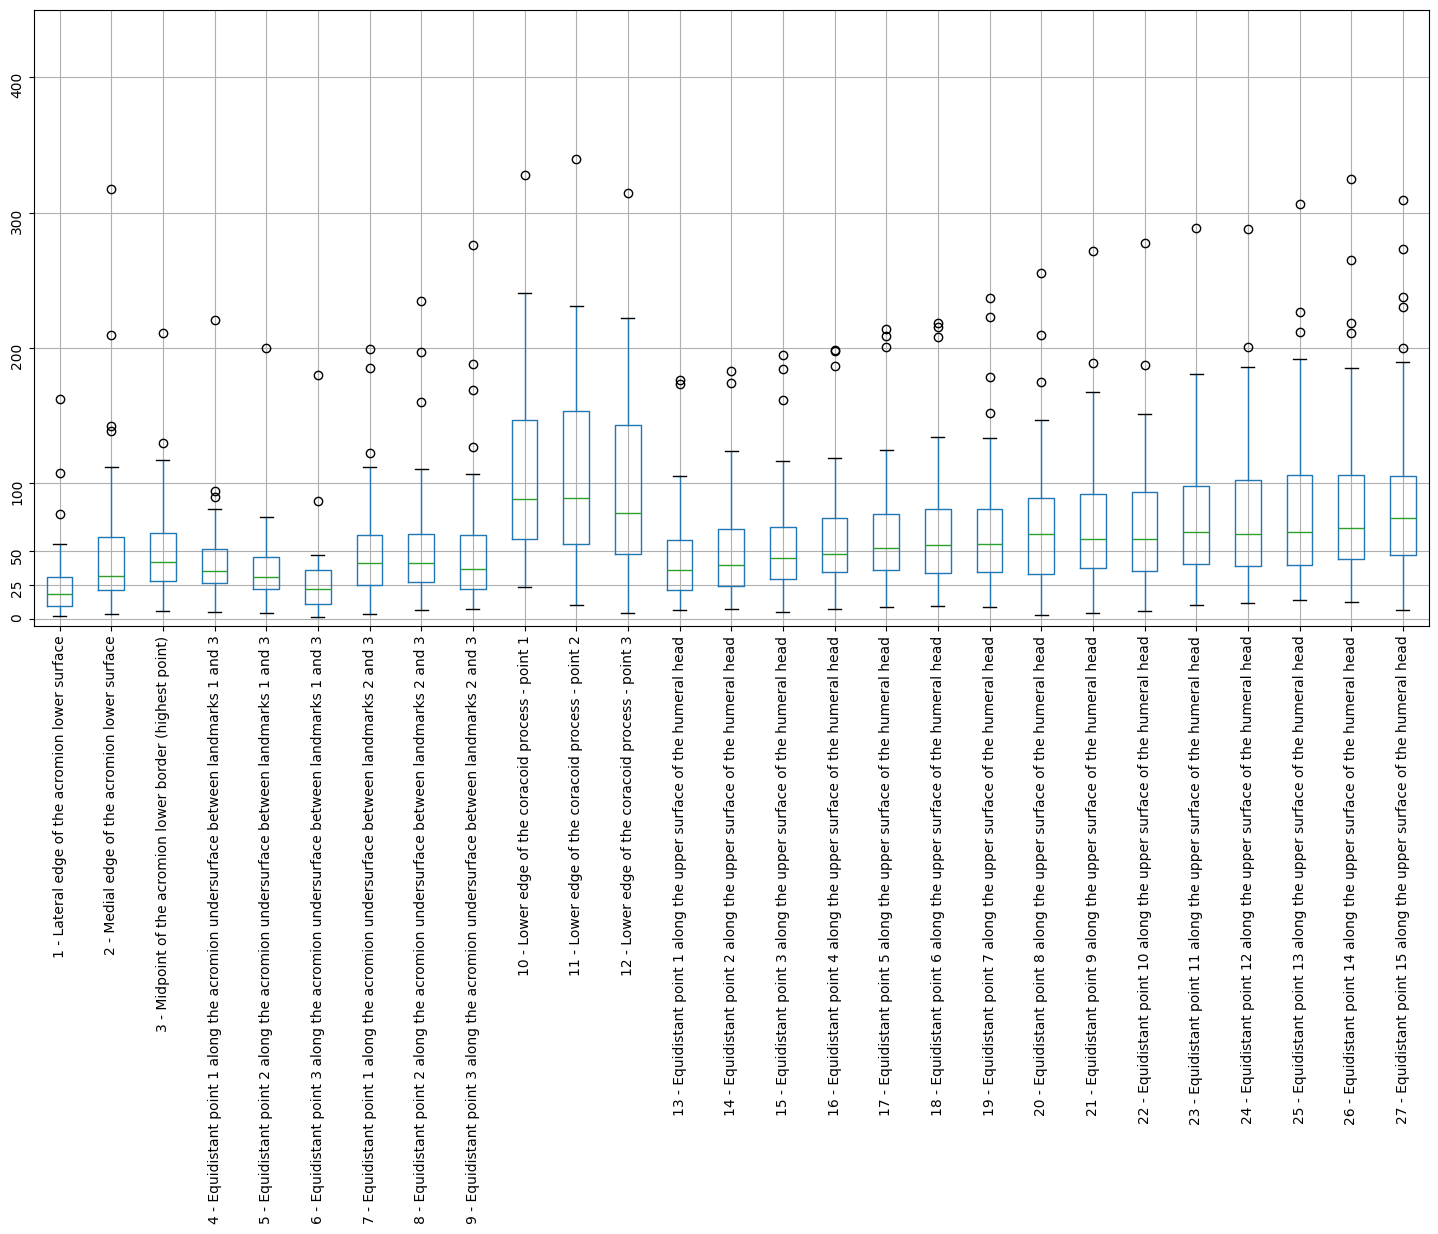

In [34]:
# Plot results
dist_dataframe = pd.DataFrame(distance_dict)
dist_dataframe.boxplot(rot=90, fontsize=10, figsize=[18,8])
plt.ylim([-5,450])
plt.yticks([0, 25,50,100,200,300,400], rotation=90)
plt.show()